In [ ]:
# Install packages
# Remember to Restart runtime after installation
# Run in ethicon environment

# Change the versions to match the ones present in the docker image
# !pip install itk==5.3rc4
# !pip install vtk
# !pip install itkwidgets
# !pip install icon-registration==0.3.4
# !pip install graphviz
# !pip install tornado==6.1
# !pip install coiled==0.0.76
# !pip install dask==2022.03.0
# !pip install distributed==2022.3.0
# !pip install boto3
# !pip install jupyter
# !pip install pandas==1.4.3
# !pip install numpy==1.21.5
# !pip install lz4==4.0.0
# !pip install git+https://github.com/uncbiag/mermaid.git
# !pip install git+https://github.com/uncbiag/easyreg.git
# !pip install git+https://github.com/PranjalSahu/OAI_analysis_2.git#egg=oai_package

In [11]:
# All Imports

import coiled
import dask
from dask import compute, visualize, delayed

import itk
import vtk
import itkwidgets
from oai_analysis_2 import dask_processing as dp
import matplotlib.pyplot as plt

In [2]:
# Create Coiled Cluster with 2 workers

name = 'oai-processing21'

cluster = coiled.Cluster(
    n_workers=2,
    scheduler_cpu=4,
    scheduler_memory="16 GiB",
    worker_cpu=4,
    worker_memory="16 GiB",
    worker_gpu=1,
    name=name,
    worker_class="dask_cuda.CUDAWorker",
    software="gpu-test9",
)

client = dask.distributed.Client(cluster)

cluster

Output()

Using existing cluster: 'oai-processing21'

Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | client         | scheduler      | workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 2.0.0          | 2.1.0          | 2.1.0          |
| pandas      | 1.3.1          | 1.4.2          | 1.4.2          |
| python      | 3.8.12.final.0 | 3.9.13.final.0 | 3.9.13.final.0 |
+-------------+----------------+----------------+----------------+


In [3]:
# Main execution block


@delayed
def deform_probmap_delayed(phi_AB, image_A, image_B, prob, image_type='FC'):
    import itk

    phi_AB1 = itk.transform_from_dict(phi_AB)

    def set_parameters(phi_AB, phi_AB1):
        for i in range(len(phi_AB) - 1):
            transform1 = phi_AB1.GetNthTransform(i)

            fp = phi_AB[i + 1]['fixedParameters']
            o1 = transform1.GetFixedParameters()
            o1.SetSize(fp.shape[0])
            for j, v in enumerate(fp):
                o1.SetElement(j, v)
            transform1.SetFixedParameters(o1)

            p = phi_AB[i + 1]['parameters']
            o2 = transform1.GetParameters()
            o2.SetSize(p.shape[0])
            for j, v in enumerate(p):
                o2.SetElement(j, v)
            transform1.SetParameters(o2)

    set_parameters(phi_AB, phi_AB1)
    image_A = itk.image_from_dict(image_A)
    image_B = itk.image_from_dict(image_B)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)

    prob = itk.image_from_dict(prob)

    warped_image = itk.resample_image_filter(
        prob,
        transform=phi_AB1,
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin())

    output_dict = itk.dict_from_image(warped_image)
    return output_dict


@delayed(nout=2)
def segment_method(image_A):
    import oai_analysis_2
    import torch
    import os
    from os.path import exists
    from oai_analysis_2 import utils
    from oai_analysis_2.segmentation import segmenter
    import boto3
    import itk
    import time

    if torch.cuda.is_available():
        device = "cuda"
    else:
        print("WARNING: CUDA NOT AVAILABLE, FALLING BACK TO CPU")
        device = "cpu"

    # Initialize segmenter
    segmenter_config = dict(
        ckpoint_path=os.path.join(utils.get_data_dir(),
                                  "segmentation_model.pth.tar"),
        training_config_file=os.path.join(utils.get_data_dir(),
                                          "segmentation_train_config.pth.tar"),
        device=device,
        batch_size=4,
        overlap_size=(16, 16, 8),
        output_prob=True,
        output_itk=True,
    )

    segmenter = oai_analysis_2.segmentation.segmenter.Segmenter3DInPatchClassWise(
        mode="pred", config=segmenter_config)

    # Download image
    timestamp = time.time()
    filename = timestamp + '.nii.gz'
    s3 = boto3.resource("s3")
    bucket_name = 'oaisample1'
    bucket = s3.Bucket(bucket_name)
    s3.Bucket(bucket_name).download_file(image_A, filename)

    # Read downloaded image
    test_volume = itk.imread(filename, itk.F)
    FC_probmap, TC_probmap = segmenter.segment(test_volume,
                                               if_output_prob_map=True,
                                               if_output_itk=True)

    return itk.dict_from_image(FC_probmap), itk.dict_from_image(TC_probmap)


fc_probmap, tc_probmap = dp.segment_method('image_preprocessed.nii.gz')
phi_AB, image_A, image_B = dp.register_images_delayed(
    'image_preprocessed.nii.gz', 'atlas_image.nii.gz')

deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, fc_probmap,
                                        'FC')
deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, tc_probmap,
                                        'TC')

thickness_fc = dp.get_thickness(deformed_fc, 'FC')
thickness_tc = dp.get_thickness(deformed_tc, 'TC')

result = [thickness_fc, thickness_tc]

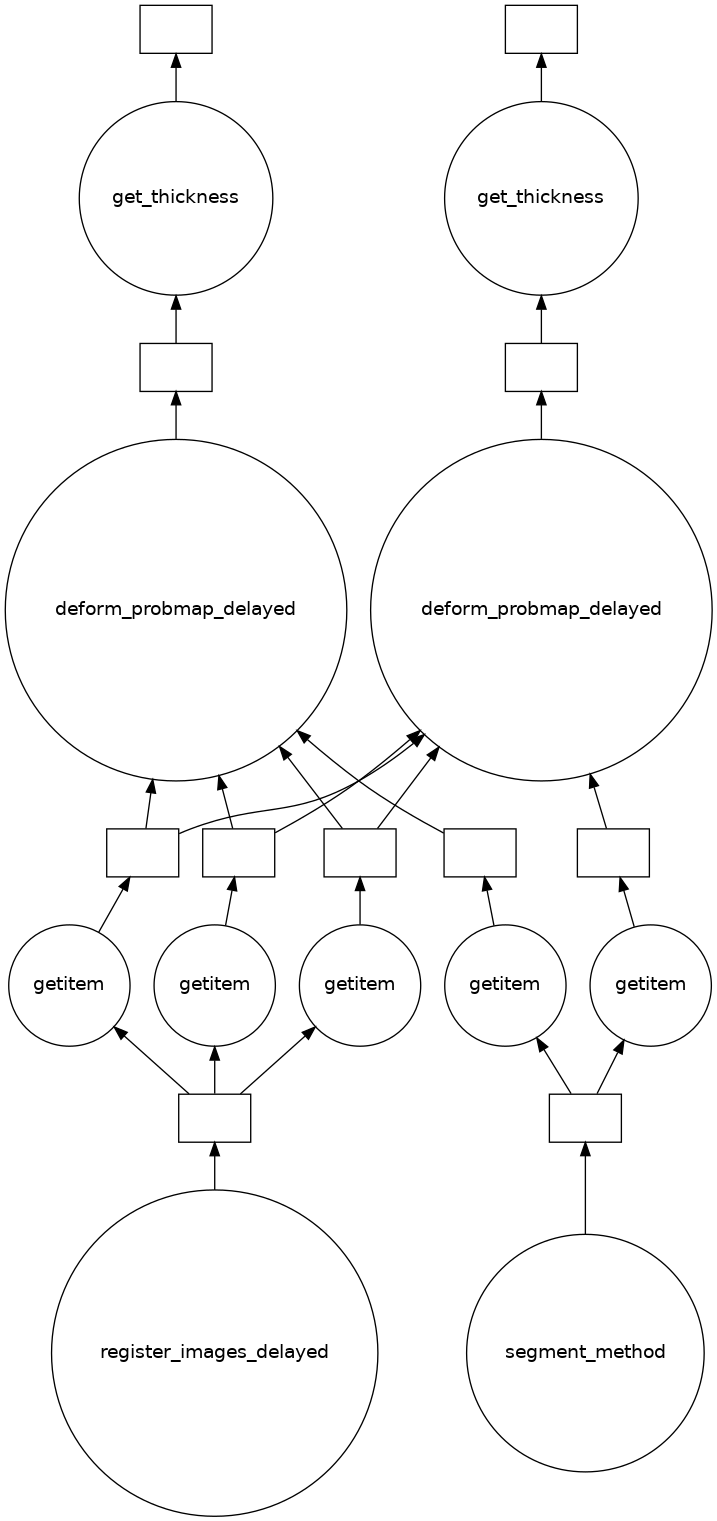

In [4]:
# Visualize Dask Computation Graph

visualize(result)

In [6]:
%%time

output_result = compute(result)

CPU times: user 94.1 ms, sys: 0 ns, total: 94.1 ms
Wall time: 1min 4s


In [7]:
# Write the meshes as vtk files

distance_inner_FC = itk.mesh_from_dict(output_result[0][0])
distance_inner_TC = itk.mesh_from_dict(output_result[0][1])

itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

In [8]:
# Read the meshes for viewing

v1 = vtk.vtkPolyDataReader()
v1.SetFileName('itk_distance_inner_FC.vtk')
v1.Update()
m1 = v1.GetOutput()

v2 = vtk.vtkPolyDataReader()
v2.SetFileName('itk_distance_inner_TC.vtk')
v2.Update()
m2 = v2.GetOutput()

In [9]:
# Visualize the meshes

itkwidgets.view(geometries=[m1, m2])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [10]:
cluster.close()

Cluster deleted successfully.

2022-06-04 15:12:21,105 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [15]:
# Code to download file from S3 using URI

import boto3

image_A = '9010060/MR_SAG_3D_DESS/RIGHT_KNEE/12_MONTH/image_preprocessed.nii.gz'
bucket_name = 'oaisample1'

s3 = boto3.resource('s3')
s3.Bucket(bucket_name).download_file(image_A, 'image_preprocessed.nii.gz')